In [1]:
import os
import natsort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from facenet_pytorch import InceptionResnetV1

In [2]:
# training transformation
train_transform = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    transforms.RandomCrop(128, padding=8)
])

# training data
train_data = datasets.ImageFolder(
    root="./train",
    transform=train_transform,
)

# -----------------------------------------------------
# validation transformation
val_transform = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

# validation data
val_data = datasets.ImageFolder(
    root="./val",
    transform=val_transform,
)

# -----------------------------------------------------
# testing transformation
test_transform = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

# modified from https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999/3
class UnlabeledDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, index):
        img_loc = os.path.join(self.main_dir, self.total_imgs[index])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

# testing data
test_data = UnlabeledDataset("./test", transform=test_transform)

In [3]:
# batch size
batch_size = 32

# total training epochs
epochs = 100

# create dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)

In [4]:
# global list for curve plotting
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Inception-Resnet v1 model pretrained on the VGGFace2 dataset
model = InceptionResnetV1(classify=True, pretrained='vggface2', num_classes=1000).to(device)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# cosine learning rate decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# cross entropy loss function
loss_fn = nn.CrossEntropyLoss()

Using cuda device


In [5]:
# training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # turn on training mode
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # compute training loss
    train_loss /= num_batches
    train_loss_list.append(train_loss)
    # compute training accuracy
    correct /= size
    train_accuracy_list.append(100*correct)
    print(f" Train accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")

# testing function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # turn on evaluation mode
    model.eval()
    val_loss, correct = 0, 0
    # turn off gradient descent
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # record loss
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # compute testing loss
    val_loss /= num_batches
    val_loss_list.append(val_loss)
    # compute testing accuracy
    correct /= size
    val_accuracy_list.append(100*correct)
    print(f" Validation accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f}")
    
# output result
def output(dataset, model):
    size = len(dataset)
    c2i = val_data.class_to_idx
    # turn on evaluation mode
    model.eval()
    pred_list = []
    # turn off gradient descent
    with torch.no_grad():
        for i in range(size):
            X = torch.unsqueeze(dataset[i], dim=0).to(device)
            pred = model(X)
            pred_list.append(int(list(c2i.keys())[list(c2i.values()).index(pred.argmax(1).item())]))
    output = {'id': np.array([str(i)+'.jpg' for i in range(size)]), 'label': np.array(pred_list)}
    output_df = pd.DataFrame(output).set_index('id')
    output_df.to_csv('output.csv')

In [6]:
for t in range(epochs):
    print('\n', "=" * 15, "Epoch", t + 1, "=" * 15)
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
    scheduler.step()

print(" Done!")


 =============== Epoch 1 ===============
 Train accuracy: 23.4%, Avg loss: 4.365234
 Validation accuracy: 44.3%, Avg loss: 2.808969

 =============== Epoch 2 ===============
 Train accuracy: 59.1%, Avg loss: 2.047037
 Validation accuracy: 65.0%, Avg loss: 1.618879

 =============== Epoch 3 ===============
 Train accuracy: 71.2%, Avg loss: 1.335536
 Validation accuracy: 71.3%, Avg loss: 1.279201

 =============== Epoch 4 ===============
 Train accuracy: 76.4%, Avg loss: 1.046141
 Validation accuracy: 73.7%, Avg loss: 1.149000

 =============== Epoch 5 ===============
 Train accuracy: 79.7%, Avg loss: 0.870448
 Validation accuracy: 76.6%, Avg loss: 1.026430

 =============== Epoch 6 ===============
 Train accuracy: 81.9%, Avg loss: 0.748928
 Validation accuracy: 76.9%, Avg loss: 1.030671

 =============== Epoch 7 ===============
 Train accuracy: 84.0%, Avg loss: 0.657765
 Validation accuracy: 77.8%, Avg loss: 0.948683

 =============== Epoch 8 ===============
 Train accuracy: 85.2%, Avg

 Train accuracy: 99.6%, Avg loss: 0.031788
 Validation accuracy: 86.1%, Avg loss: 0.673328

 =============== Epoch 63 ===============
 Train accuracy: 99.6%, Avg loss: 0.030245
 Validation accuracy: 85.5%, Avg loss: 0.657809

 =============== Epoch 64 ===============
 Train accuracy: 99.7%, Avg loss: 0.028990
 Validation accuracy: 85.4%, Avg loss: 0.662064

 =============== Epoch 65 ===============
 Train accuracy: 99.7%, Avg loss: 0.027189
 Validation accuracy: 86.2%, Avg loss: 0.648263

 =============== Epoch 66 ===============
 Train accuracy: 99.7%, Avg loss: 0.026452
 Validation accuracy: 85.8%, Avg loss: 0.638267

 =============== Epoch 67 ===============
 Train accuracy: 99.8%, Avg loss: 0.025003
 Validation accuracy: 85.9%, Avg loss: 0.647274

 =============== Epoch 68 ===============
 Train accuracy: 99.8%, Avg loss: 0.023594
 Validation accuracy: 86.6%, Avg loss: 0.631744

 =============== Epoch 69 ===============
 Train accuracy: 99.8%, Avg loss: 0.022904
 Validation accurac

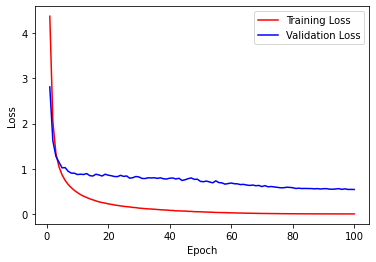

In [7]:
# plot training and validation loss
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot([_+1 for _ in range(epochs)], train_loss_list, 'r', label="Training Loss")
plt.plot([_+1 for _ in range(epochs)], val_loss_list, 'b', label="Validation Loss")
plt.legend()

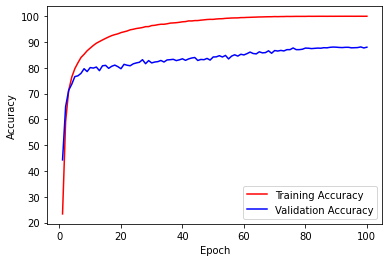

In [8]:
# plot training and validation accuracy
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot([_+1 for _ in range(epochs)], train_accuracy_list, 'r', label="Training Accuracy")
plt.plot([_+1 for _ in range(epochs)], val_accuracy_list, 'b', label="Validation Accuracy")
plt.legend()

In [9]:
# save the model
path = "./aist4010-asm1.pth"
torch.save(model.state_dict(), path)

# output the result
output(test_data, model)